In [1]:
import sys
if True:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else:
    root = './'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda')
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [0]:
import importlib
import util
importlib.reload(util)
from util import *

In [0]:
# TODO: test loss and validation loss

In [0]:
loss = torch.nn.MSELoss()

In [0]:
def train_it(dataset, model, Npast=1, Nfuture=1):
    #model = model
    learning_rate = 1e-4
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    Nepoch = 1000
    Nbatch = 100
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset)
        y_pred = model(xx)+xx
        L = loss(y_pred,yy)
        h = y_pred
        #for i in range(Nfuture-1):
            
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            losses[e//Nsave,0] = L.item()
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
    return losses

In [0]:
stash = {}

In [6]:
for dataname in ["heat"]:
    data = np.load(root+f"data/{dataname}.npz")
    dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
    Ntraj,Nt,Nx = dataset.shape
    for name, cls in models.items():
        print("Training ",name)
        model = cls(Nx).to(device)
        results = train_it(dataset,model)
        stash[name] = {'model':model,
                       'loss':results}

Training  PureStencil
469 0.028794584795832634
939 0.010524822399020195
1409 0.007747179828584194
1879 0.006241599563509226
2349 0.007753980346024036
2819 0.004830036778002977
3289 0.006007112562656403
3759 0.00613001175224781
4229 0.005127914249897003
4699 0.003962170798331499
Training  PureLinear


TypeError: ignored

In [0]:
for N,S in stash.items():
    plt.semilogy(S['loss'][:,0],label=N)
plt.legend()

PureStencil


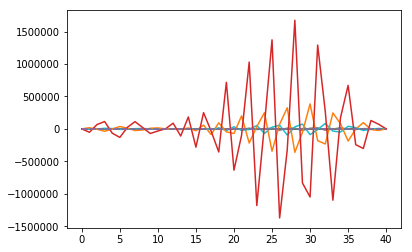

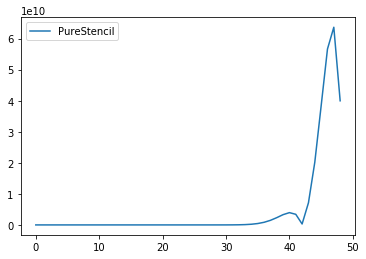

In [7]:
err = {}
for N,S in stash.items():
    print(N)
    err[N] = do_a_path(S['model'],dataset,5)
for N,e in err.items():
    plt.plot(e,label=N)
plt.legend()
plt.show()


In [8]:
list(stash["PureStencil"]['model'].parameters())

[Parameter containing:
 tensor([[[ 0.3745,  0.1293, -0.5189]]], device='cuda:0', requires_grad=True)]

In [0]:
outfile = open(root+'/db','wb')
torch.save(stash,outfile)
outfile.close()

In [1]:
stash['PureStencil']['model'].parameters()

NameError: ignored